# CNN Architecture: Flower Image Recognition
*Deep Learning Project*

- To better understand a network I built and train the ResNet50 network architecture from scratch (without pretrained library) for image classification using Keras.
- Flower image recognition application.
- Note: for more regular use it is faster to use pretrained ResNet50 in Keras.

## Load Packages

In [2]:
#!pip install pydot

In [3]:
import os
import glob
import cv2
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
from skimage import io
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
import imageio
import pydot

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


## Load Dataset
The Flowers dataset has a image collection of 5 types of flowers that will be represented from 0 to 4.<br>
Link to dataset: https://www.kaggle.com/alxmamaev/flowers-recognition
- Daisy: 0
- Dandelion: 1
- Rose: 2
- Sunflower: 3
- Tulip: 4

In [4]:
def load_dataset(directory, classes): 
    """
    Load flowers dataset and preprocess images to 64 x 64 x 3 size.
    
    Arguments:
    directory -- string with directory path
    classes -- list of flower type names
    
    Returns: 
    X_orig -- np.array containing all images
    y_orig -- np.array containing all image labels
    """
    paths = [] # store image paths
    y_orig = [] # store class number
    for category in classes:
        flower_path = os.path.join(directory, category, '*')
        flower_path = glob.glob(flower_path)
        for img_path in flower_path:
            if img_path.endswith('.jpg'):
                paths.append(img_path)
                y_orig.append(classes.index(category))
    
    X_orig = []
    for i in range(len(paths)):
        if paths[i].endswith('.jpg'):
            img = cv2.imread (paths[i])
            img_res = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_AREA) #standardaze image size 
            X_orig.append(img_res)
    
    X_orig = np.array(X_orig)
    y_orig = np.array(y_orig)
    y_orig = y_orig.reshape((1, y_orig.shape[0]))
        
    return X_orig, y_orig, paths   

In [5]:
#helper code
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [6]:
#init directory      
directory = '/kaggle/input/flowers-recognition/flowers'
#flower categories
classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'] # 0 to 4

X_orig, Y_orig, paths = load_dataset(directory, classes)

# Normalize image vector
X = X_orig/255.

# Convert labels to one hot matrices
y = convert_to_one_hot(Y_orig, 5).T

print ("number of examples = " + str(X.shape[0]))
print ("X shape: " + str(X.shape))
print ("y shape: " + str(y.shape))

number of examples = 4323
X shape: (4323, 64, 64, 3)
y shape: (4323, 5)


## Implementing a Residual Network - 50 layers

**References:** 
This build is based on the ResNet algorithm due to He et al. (2015) that was also presented in the Deep Learning Specialization on Coursera. The implementation here also took significant inspiration and follows the structure given in the GitHub repository of Francois Chollet. 
* Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
* Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py

### The identity block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation has the same dimension as the output activation.

In [7]:
def identity_block(X, f, filters, stage, block, reg=1e-4):
    """
    Implementation of the identity block that skips over 3 hidden layers
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', 
               name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0),
               kernel_regularizer=l2(reg))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', 
               name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0), 
               kernel_regularizer=l2(reg))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', 
               name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0),
               kernel_regularizer=l2(reg))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

## The convolutional block

The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path.

In [8]:
def convolutional_block(X, f, filters, stage, block, s = 2, reg=1e-4):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding='valid', 
               name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0), 
               kernel_regularizer=l2(reg))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), padding='same', 
               name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0),
               kernel_regularizer=l2(reg))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), padding='valid', 
               name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0),
               kernel_regularizer=l2(reg))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding='valid', 
                        name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0),
                        kernel_regularizer=l2(reg))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

### ResNet50

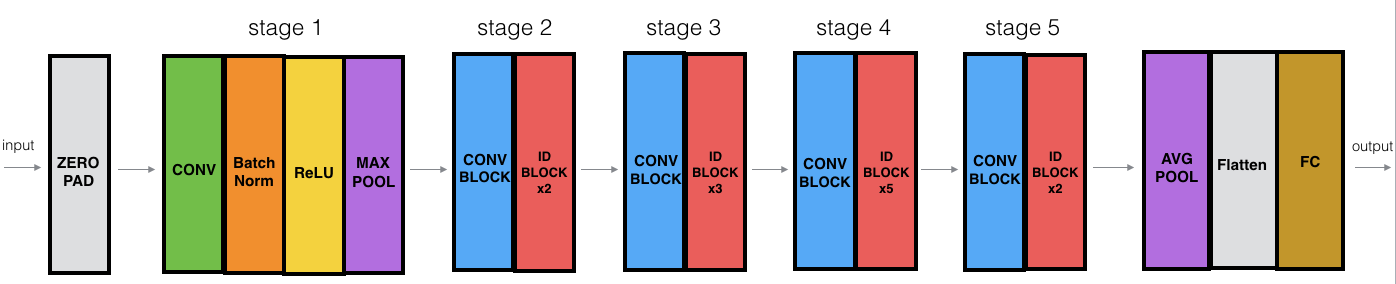

In [9]:
def ResNet50(input_shape = (64, 64, 3), classes = 5, reg=1e-4):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(128, (7, 7), strides = (2, 2), name = 'conv1', 
               kernel_initializer = glorot_uniform(seed=0), kernel_regularizer=l2(reg))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), 
              kernel_initializer = glorot_uniform(seed=0), kernel_regularizer=l2(reg))(X)

    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

## Split train & test set

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=27)
train_paths, test_paths, _, _ = train_test_split(paths, y, test_size=0.1, random_state=27)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', Y_train.shape)
print('y_test shape:', Y_test.shape)

X_train shape: (3890, 64, 64, 3)
X_test shape: (433, 64, 64, 3)
y_train shape: (3890, 5)
y_test shape: (433, 5)


## Data Augmentation to prevent Overfitting

In [11]:
gen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
                             samplewise_center=False,  # set each sample mean to 0
                             featurewise_std_normalization=False,  # divide inputs by std of the dataset
                             samplewise_std_normalization=False,  # divide each input by its std
                             zca_whitening=False,  # apply ZCA whitening
                             rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                             zoom_range = 0.1, # Randomly zoom image 
                             width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=False)  # randomly flip images

gen.fit(X_train)

## Train & Predict

In [12]:
# build the model's graph
model = ResNet50(input_shape = (64, 64, 3), classes = 5)

# configure the learning process
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
#train and store details
cache = model.fit(gen.flow(X_train, Y_train, batch_size=10),
                           epochs = 84, validation_data = (X_test, Y_test),
                           steps_per_epoch = X_train.shape[0] // 10)

Epoch 1/84
389/389 [==============================] - 24s 42ms/step - loss: 4.2555 - accuracy: 0.2944 - val_loss: 4.4583 - val_accuracy: 0.3349
Epoch 2/84
389/389 [==============================] - 14s 36ms/step - loss: 3.2129 - accuracy: 0.4655 - val_loss: 3.8573 - val_accuracy: 0.3187
Epoch 3/84
389/389 [==============================] - 14s 37ms/step - loss: 3.0983 - accuracy: 0.4835 - val_loss: 2.6723 - val_accuracy: 0.4665
Epoch 4/84
389/389 [==============================] - 14s 36ms/step - loss: 2.7162 - accuracy: 0.5308 - val_loss: 3.1092 - val_accuracy: 0.4942
Epoch 5/84
389/389 [==============================] - 14s 36ms/step - loss: 2.6332 - accuracy: 0.4943 - val_loss: 2.8863 - val_accuracy: 0.4065
Epoch 6/84
389/389 [==============================] - 15s 38ms/step - loss: 2.2329 - accuracy: 0.5554 - val_loss: 1.9835 - val_accuracy: 0.6374
Epoch 7/84
389/389 [==============================] - 14s 36ms/step - loss: 2.1070 - accuracy: 0.5612 - val_loss: 3.8674 - val_accuracy:

389/389 [==============================] - 14s 36ms/step - loss: 0.9026 - accuracy: 0.7330 - val_loss: 0.9722 - val_accuracy: 0.6975
Epoch 59/84
389/389 [==============================] - 14s 36ms/step - loss: 0.8829 - accuracy: 0.7387 - val_loss: 1.2612 - val_accuracy: 0.6282
Epoch 60/84
389/389 [==============================] - 15s 37ms/step - loss: 0.9240 - accuracy: 0.7274 - val_loss: 0.8549 - val_accuracy: 0.7691
Epoch 61/84
389/389 [==============================] - 14s 36ms/step - loss: 0.8914 - accuracy: 0.7360 - val_loss: 1.1136 - val_accuracy: 0.6582
Epoch 62/84
389/389 [==============================] - 15s 37ms/step - loss: 0.8842 - accuracy: 0.7435 - val_loss: 1.0799 - val_accuracy: 0.6674
Epoch 63/84
389/389 [==============================] - 14s 36ms/step - loss: 0.8705 - accuracy: 0.7581 - val_loss: 1.0545 - val_accuracy: 0.6605
Epoch 64/84
389/389 [==============================] - 14s 37ms/step - loss: 0.8313 - accuracy: 0.7570 - val_loss: 2.7708 - val_accuracy: 0.35

In [14]:
# evaluate model performance
preds = model.evaluate(X_test, Y_test)
print ("Test Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

14/14 [==============================] - 0s 15ms/step - loss: 0.8473 - accuracy: 0.7229
Test Loss = 0.8472915291786194
Test Accuracy = 0.7228637337684631


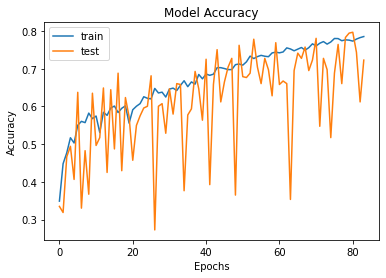

In [15]:
# summarize history for accuracy
plt.plot(cache.history['accuracy'])
plt.plot(cache.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

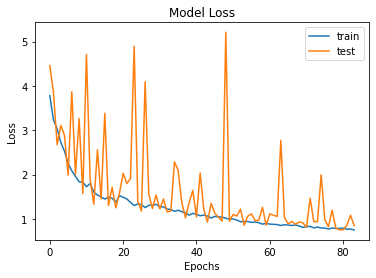

In [16]:
# summarize history for loss
plt.plot(cache.history['loss'])
plt.plot(cache.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

Image size = (64, 64, 3) 
Expected y = [0. 1. 0. 0. 0.]
Image path: /kaggle/input/flowers-recognition/flowers/dandelion/14306875733_61d71c64c0_n.jpg
Class prediction vector [p(0), p(1), p(2), p(3), p(4)] = [[0.2  0.48 0.21 0.02 0.08]]
Prediction: dandelion


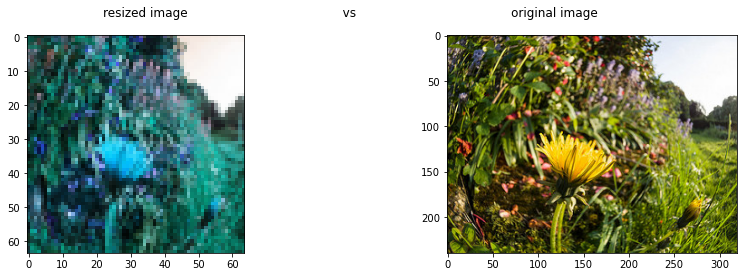

In [22]:
def viz_pred():
    """Visualize results"""
    # plotting the original image and image used in model
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_figwidth(15)

    # random picture index
    index = random.randint(0, len(X_test))

    #process image 1
    ax1.imshow(X_test[index])
    print ('Image size =', X_test[index].shape, '\nExpected y =', str(np.squeeze(Y_test[index])))

    #process image 2
    img_path = test_paths[index]
    print('Image path:',img_path)
    img = image.load_img(img_path, target_size=(64, 64))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x/255.0
    my_image = imageio.imread(img_path)
    ax2.imshow(my_image)

    #prediction
    probs_pred = model.predict(x).round(2)
    print("Class prediction vector [p(0), p(1), p(2), p(3), p(4)] =", probs_pred)
    probs_pred = probs_pred[0].tolist()
    max_value = max(probs_pred)
    print("Prediction:", classes[probs_pred.index(max_value)])

    f.suptitle('resized image                                        vs                                        original image')
    return plt.show()

viz_pred()

Image size = (64, 64, 3) 
Expected y = [0. 0. 0. 1. 0.]
Image path: /kaggle/input/flowers-recognition/flowers/sunflower/147804446_ef9244c8ce_m.jpg
Class prediction vector [p(0), p(1), p(2), p(3), p(4)] = [[0.23 0.57 0.05 0.03 0.12]]
Prediction: dandelion


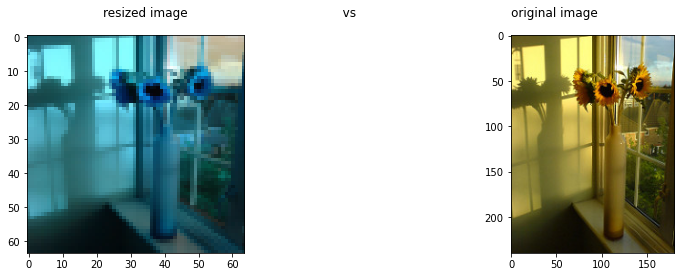

In [25]:
viz_pred()

Image size = (64, 64, 3) 
Expected y = [0. 1. 0. 0. 0.]
Image path: /kaggle/input/flowers-recognition/flowers/dandelion/9111669902_9471c3a49c_n.jpg
Class prediction vector [p(0), p(1), p(2), p(3), p(4)] = [[0.   0.99 0.   0.   0.  ]]
Prediction: dandelion


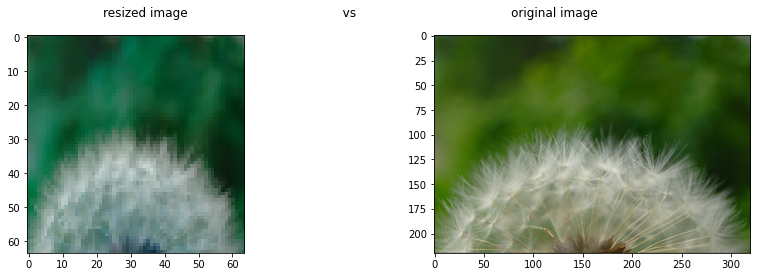

In [28]:
viz_pred()

Image size = (64, 64, 3) 
Expected y = [0. 0. 1. 0. 0.]
Image path: /kaggle/input/flowers-recognition/flowers/rose/18464055536_709c8af0b7_n.jpg
Class prediction vector [p(0), p(1), p(2), p(3), p(4)] = [[0.01 0.   0.57 0.   0.41]]
Prediction: rose


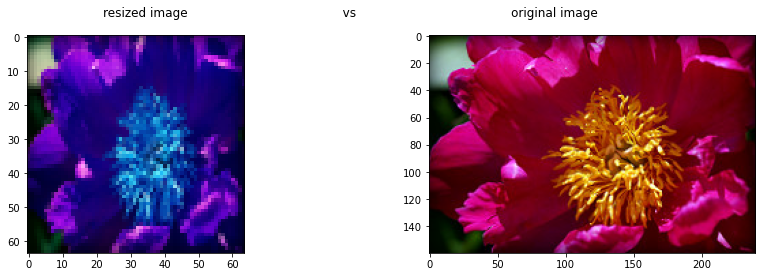

In [38]:
viz_pred()

## Summary & Visualization of ResNet50 

In [18]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 128)  18944       zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 128)  512         conv1[0][0]                      
___________________________________________________________________________________________

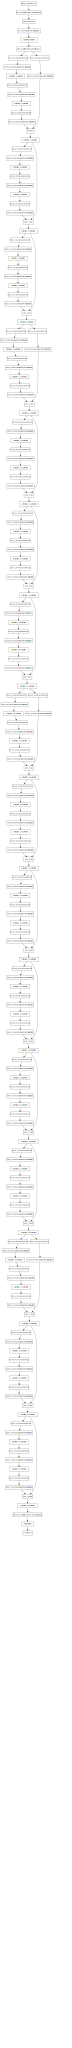

In [19]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))